This notebook explores suggestions from Joe and Kyle to speed up `QuantileCalibrator.`

In [2]:
from sklearn_helpers import QuantileCalibrator

from sklearn.datasets import make_regression

In [116]:
X, y = make_regression(n_samples=10000, n_features=10)

In [117]:
from sklearn.ensemble import RandomForestRegressor

In [118]:
rf = RandomForestRegressor(max_features=0.333, n_estimators=50, n_jobs=-1, oob_score=True)
rf.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.333, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [119]:
y_ = rf.oob_prediction_

In [147]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)

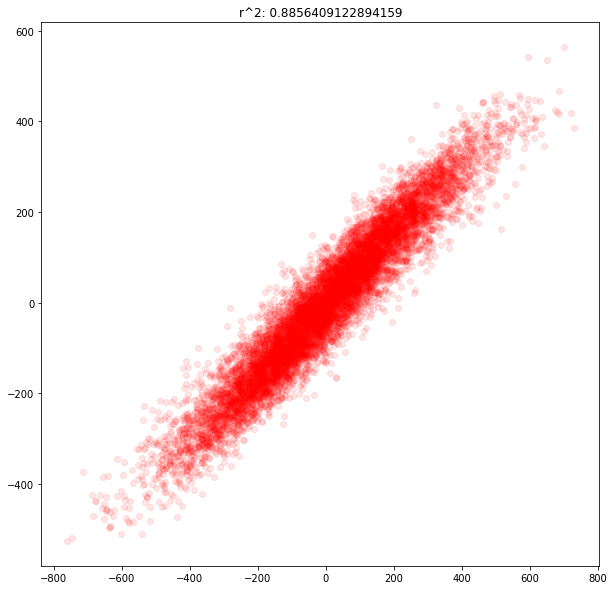

In [148]:
plt.scatter(y, y_, c='r', alpha=0.1)
plt.title('r^2: {}'.format(rf.oob_score_))
plt.show()

In [134]:
import pandas as pd

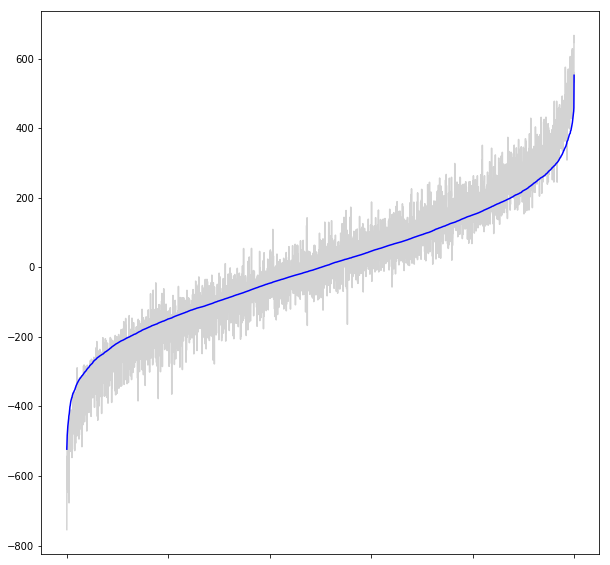

In [246]:
q = 5000
quants_y = pd.Series(y).groupby(pd.qcut(y_, q)).mean()
quants_y_ = pd.Series(y_).groupby(pd.qcut(y_, q)).mean()
quants_y.plot(c='lightgrey')
quants_y_.plot(c='blue')
plt.show()

In [247]:
from sklearn.isotonic import isotonic_regression

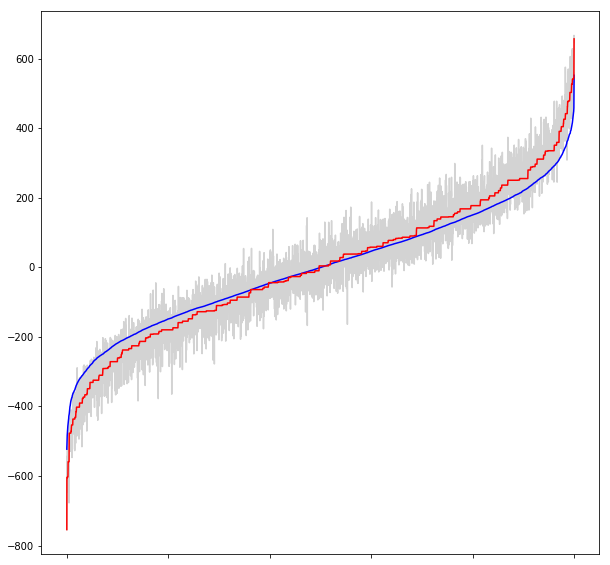

In [248]:
iso_fit = pd.Series(isotonic_regression(quants_y.values))
quants_y.plot(c='lightgrey')
quants_y_.plot(c='blue')
iso_fit.plot(c='red')
plt.show()

In [265]:
from scipy.optimize import minimize
import numpy as np

def _ls_min_func(y_fit, y, lamb):
    D3_y_fit = np.diff(np.diff(np.diff(y_fit)))

    return np.inner(y - y_fit, y - y_fit) + lamb * np.inner(D3_y_fit, D3_y_fit)

def isotonic_regression_smooth(X, lamb, good_x0=False):
    cons = ({'type': 'ineq', 'fun': lambda x: np.diff(x)})
    
    x0 = X
    if good_x0:
        x0 = isotonic_regression(X)

    return minimize(_ls_min_func,
                    x0=x0,
                    args=(X, lamb),
                    method='COBYLA',
                    constraints=cons).x

In [266]:
from time import time

time_results = {'before': [], 'kyle': []}

for i in range(50):
    start_time = time()
    isotonic_regression_smooth(quants_y.values, 1, good_x0=False)
    end_time = time()
    
    time_results['before'].append(end_time - start_time)
    
for i in range(50):
    start_time = time()
    isotonic_regression_smooth(quants_y.values, 1, good_x0=True)
    end_time = time()
    
    time_results['kyle'].append(end_time - start_time)

In [267]:
pd.DataFrame(time_results).mean()

before    0.575877
kyle      0.572537
dtype: float64

In [272]:
from sklearn.metrics import r2_score

In [273]:
r2_score(y, y_)

0.88564091228941588

In [311]:
def make_cuts(z, z_, bins, y_cut=False):
    if y_cut:
        return pd.Series(z).groupby(pd.qcut(z_, bins)).mean()
    else:
        return pd.Series(z).groupby(pd.cut(z_, bins)).mean().interpolate()

In [312]:
def _lookup(lookup_table, val):
    if val >= lookup_table.index[-1].right:
        return lookup_table.iloc[-1]
    elif val <= lookup_table.index[0].left:
        return lookup_table.iloc[0]
    else:
        return lookup_table[val]

joe_results = {'bins': [], 
               'before_r2': [], 
               'joe_r2': [], 
               'before_t': [],
               'joe_t': []}

for bins in range(100, 5000, 50):
    
    print(bins)
    
    t0 = time()
    
    before = make_cuts(y, y_, bins=bins, y_cut=False)
    y_before = np.array([_lookup(before, z) for z in y_])
    
    t1 = time()
    
    if np.isnan(y_before).any():
        print(before)
    
    t2 = time()
    
    joe = make_cuts(y, y_, bins=bins, y_cut=True)
    y_joe = np.array([_lookup(joe, z) for z in y_])
    
    t3 = time()
    
    if np.isnan(y_joe).any():
        print(joe)
    
    joe_results['bins'].append(bins)
    joe_results['before_r2'].append(r2_score(y, y_before))
    joe_results['joe_r2'].append(r2_score(y, y_joe))
    
    joe_results['before_t'].append(t1 - t0)
    joe_results['joe_t'].append(t3 - t2)

100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000
3050
3100
3150
3200
3250
3300
3350
3400
3450
3500
3550
3600
3650
3700
3750
3800
3850
3900
3950
4000
4050
4100
4150
4200
4250
4300
4350
4400
4450
4500
4550
4600
4650
4700
4750
4800
4850
4900
4950


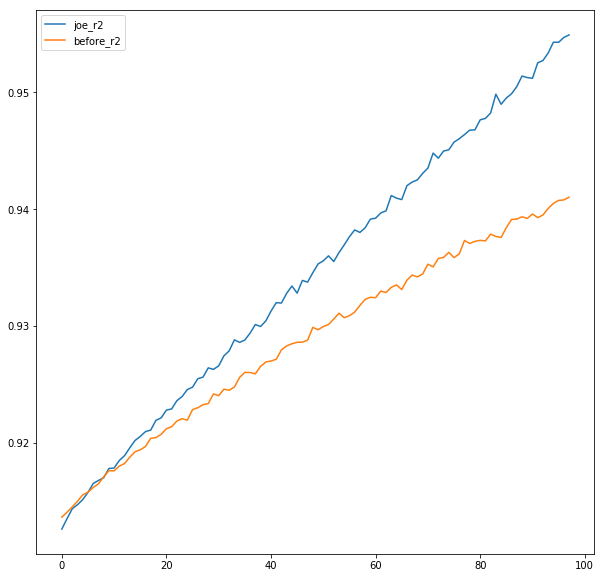

In [322]:
joe_df = pd.DataFrame(joe_results)
joe_df[['joe_r2', 'before_r2']].plot()

plt.show()

In [324]:
joe_df.mean()

before_r2       0.928831
before_t        0.685749
bins         2525.000000
joe_r2          0.934513
joe_t           0.658707
dtype: float64